**Importing the Dependencies**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Loading the Data**

In [2]:
housing = pd.read_csv('/content/drive/MyDrive/Machine Learning projects/datasets/Housing.csv')

In [3]:
housing.head()

,Unnamed: 0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing = housing.drop(['Unnamed: 0'], axis = 1)

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Plotting Hitogram to observe the frequencies

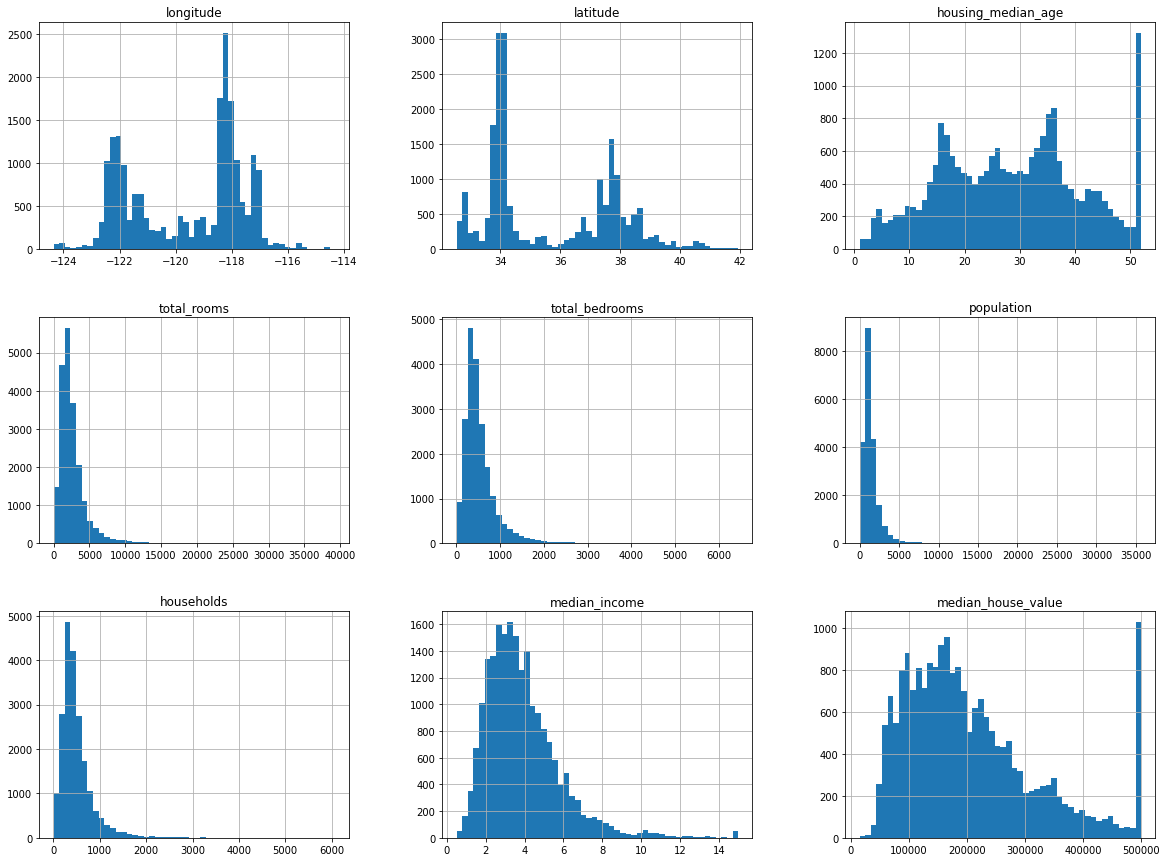

In [7]:
%matplotlib inline 
housing.hist(bins=50, figsize=(20,15))
plt.show()

Train - Test Split

In [8]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 10)


In [9]:
print(len(train_set)/len(housing))
print(len(test_set)/len(housing))

0.8
0.2


In [10]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing['income_cat'].where(housing['income_cat']<5.0, 5.0, inplace = True)

Stratified Train - Test Split

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 10)
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]


In [12]:
housing['income_cat'].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [13]:
for set in (strat_train_set, strat_test_set):
  set.drop(['income_cat'], axis = 1, inplace = True)

In [14]:
housing = strat_train_set.copy()

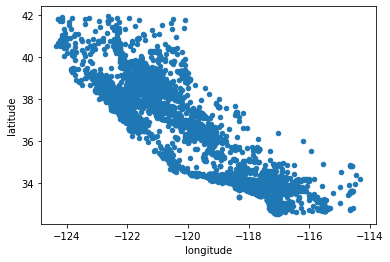

In [15]:
# scatter plot of training data without alpha
housing.plot(kind="scatter", x="longitude", y="latitude")


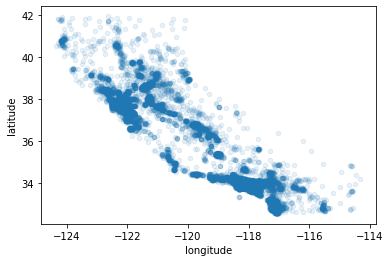

In [16]:
# scatter plot of training data with alpha
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


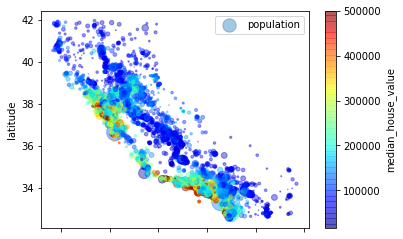

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population",
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

**Looking for correlations**

In [18]:
corr_matrix = housing.corr()

In [19]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688214
total_rooms           0.133785
housing_median_age    0.105336
households            0.065036
total_bedrooms        0.048016
population           -0.025355
longitude            -0.047002
latitude             -0.142754
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f028aac2290>,
      dtype=object)

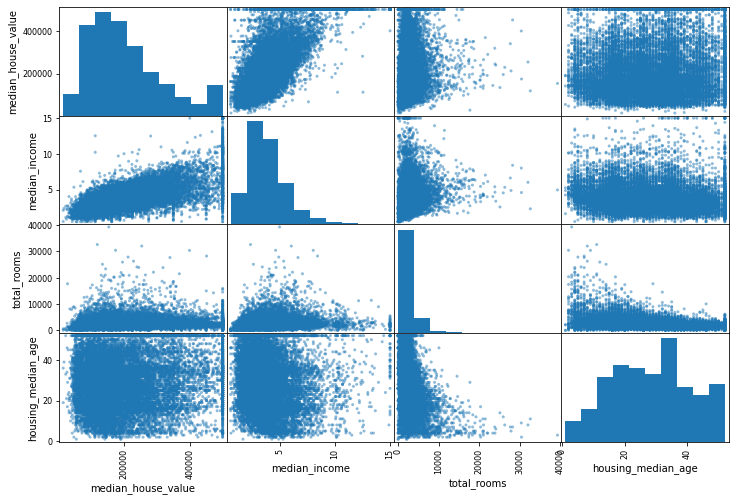

In [20]:
#using pandas plotting to look for correlations
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,8))

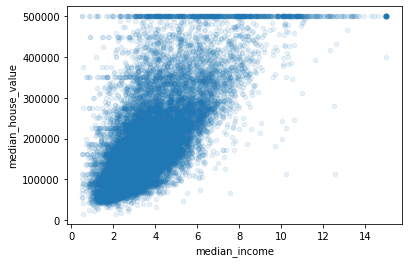

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)


In [22]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Using SimpleImputer for Data Cleaning

In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

In [24]:
housing_num = housing.drop('ocean_proximity', axis = 1)  #dropping ocean_proximity column to work with numerical values

In [25]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [26]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2129.     ,  435.     ,
       1164.     ,  410.     ,    3.53275])

In [27]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2129.     ,  435.     ,
       1164.     ,  410.     ,    3.53275])

In [28]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

Handling the Text and categorical attributes

In [29]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)


In [30]:
print(housing_cat, '\n\n')
print(housing_cat_encoded, '\n\n')
print(encoder.classes_)

6229     <1H OCEAN
4117     <1H OCEAN
13371       INLAND
16727    <1H OCEAN
7884     <1H OCEAN
           ...    
1355        INLAND
13572       INLAND
5607     <1H OCEAN
9981        INLAND
10003       INLAND
Name: ocean_proximity, Length: 16512, dtype: object 


[0 0 1 ... 0 1 1] 


['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [31]:
from sklearn.base import TransformerMixin #gives fit_transform method for free
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [32]:
# using LabelBinarizer to transform data from one categories to integera and from integers to one hot vectors
from sklearn.preprocessing import LabelBinarizer
encoder = MyLabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [33]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
6229,-117.94,34.06,32.0,3418.0,662.0,2003.0,622.0,4.0333
4117,-118.22,34.14,52.0,2298.0,406.0,1203.0,387.0,5.5291
13371,-117.54,34.11,16.0,2114.0,374.0,1463.0,399.0,3.9241
16727,-120.76,35.52,7.0,9613.0,1666.0,4487.0,1653.0,3.6667
7884,-118.13,33.87,20.0,3638.0,868.0,2326.0,822.0,3.3304
...,...,...,...,...,...,...,...,...
1355,-121.92,38.03,16.0,2176.0,464.0,1410.0,434.0,3.5436
13572,-117.28,34.14,40.0,2190.0,496.0,1214.0,493.0,2.3947
5607,-118.30,33.79,21.0,1068.0,283.0,1180.0,274.0,2.5000
9981,-122.27,38.53,22.0,678.0,137.0,336.0,103.0,4.4000


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy="median")),
 ('std_scaler', StandardScaler()),
 ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
 def __init__(self, attribute_names):
  self.attribute_names = attribute_names
 def fit(self, X, y=None):
  return self
 def transform(self, X):
  return X[self.attribute_names].values

In [36]:
from sklearn.pipeline import FeatureUnion
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
 ('selector', DataFrameSelector(num_attribs)),
 ('imputer', SimpleImputer(strategy="median")),
 ('std_scaler', StandardScaler()),
 ])
cat_pipeline = Pipeline([
 ('selector', DataFrameSelector(cat_attribs)),
 ('label_binarizer', MyLabelBinarizer()),
 ])
full_pipeline = FeatureUnion(transformer_list=[
 ("num_pipeline", num_pipeline),
 ("cat_pipeline", cat_pipeline),
 ])


In [37]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[ 0.81471209, -0.73814404,  0.26241444, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67548395, -0.70078874,  1.84967647, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.01360943, -0.71479698, -1.00739518, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.63570448, -0.86421816, -0.61057968, ...,  0.        ,
         0.        ,  0.        ],
       [-1.33835161,  1.34908308, -0.53121657, ...,  0.        ,
         0.        ,  0.        ],
       [-0.72176986,  1.5918925 , -1.32484759, ...,  0.        ,
         0.        ,  0.        ]])

In [38]:
housing_prepared.shape

(16512, 13)

**Selecting and Training the Model**



> 1. Linear Regression



In [39]:
# Training the linear regression  model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


LinearRegression()

In [40]:
# preparing some data to look for model predictions
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [41]:
# looking for model predictions and True Labels
print('prediction : ',lin_reg.predict(some_data_prepared))
print('Labels : ',some_labels)

prediction :  [217739.17962079 303063.32491776 134412.73930818 239255.50673391
 204239.39615283]
Labels :  6229     210200.0
4117     274600.0
13371    131500.0
16727    250600.0
7884     194600.0
Name: median_house_value, dtype: float64


In [42]:
# Assessing the performance of model on training set
# 1. Mean squared error/ Root mean squared Error
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse=  mean_squared_error(housing_predictions, housing_labels)
lin_rmse  = np.sqrt(lin_mse)
lin_rmse

68728.3926974517

In [43]:
# 2. Mean absolute Error
from sklearn.metrics import mean_absolute_error
lin_mae=  mean_absolute_error(housing_predictions, housing_labels)
lin_mae

49931.0068751948



> 2. DecisionTreeRegressor



In [44]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)

In [45]:
tree_mse = mean_squared_error(housing_predictions, housing_labels)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Better Evaluation Using Cross Validation

In [46]:
from sklearn.model_selection import cross_val_score
tree_scores=  cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [47]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())


In [48]:
display_scores(tree_rmse_scores)

Scores: [70194.56928561 67512.27746236 71631.65643964 69114.44752363
 73386.19017301 67381.85748969 69440.54242454 68866.08276464
 67445.64196106 65758.02179081]
Mean: 69073.12873149857
Standard deviation: 2133.566552950893


In [49]:
lin_scores=  cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [70809.55708155 68385.1849776  72619.83914697 71172.12783823
 69571.30413525 66387.50517152 68886.82503704 66768.76409803
 67596.38778979 66559.03709176]
Mean: 68875.65323677112
Standard deviation: 2034.4634424289343


Training and Evaluating RandomForestRegressor

In [50]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)


RandomForestRegressor()

In [51]:
forest_mse = mean_squared_error(housing_predictions, housing_labels)
forest_rmse = np.sqrt(tree_mse)
forest_rmse

0.0

In [52]:
# # cross_validation.....only execute if necessary...takes a long time
# forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
# forest_rmse_scores = np.sqrt(-forest_scores)
# display_scores(forest_rmse_scores)

Saving the Models

In [53]:
import joblib
joblib.dump(lin_reg, "LinearRegression_on_housing_data.pkl")
joblib.dump(tree_reg, "DecisionTreeRegression_on_housing_data.pkl")
joblib.dump(lin_reg, "RandomForestRegression_on_housing_data.pkl")

['RandomForestRegression_on_housing_data.pkl']

Using the Models

In [54]:
import joblib
import numpy as np
linear_model = joblib.load("LinearRegression_on_housing_data.pkl")
features = np.array([[-117.94,34.06,32,3418,662,2003,622,4.033,1,0,0,0,0]])
linear_model.predict(features)

array([-84197235.80093926])

In [55]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
6229,-117.94,34.06,32.0,3418.0,662.0,2003.0,622.0,4.0333,<1H OCEAN
4117,-118.22,34.14,52.0,2298.0,406.0,1203.0,387.0,5.5291,<1H OCEAN
13371,-117.54,34.11,16.0,2114.0,374.0,1463.0,399.0,3.9241,INLAND
16727,-120.76,35.52,7.0,9613.0,1666.0,4487.0,1653.0,3.6667,<1H OCEAN
7884,-118.13,33.87,20.0,3638.0,868.0,2326.0,822.0,3.3304,<1H OCEAN


In [56]:
housing_prepared.shape

(16512, 13)

Evaluating the Models on Test Set



>1. RandomForestRegressor



In [63]:
X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
forest_final_predictions = forest_reg.predict(X_test_prepared)
forest_final_mse = mean_squared_error(y_test, forest_final_predictions)
forest_final_rmse = np.sqrt(forest_final_mse)
forest_final_rmse

49398.523905896



>DecisionTreeRegressor



In [61]:
tree_final_predictions = tree_reg.predict(X_test_prepared)
tree_final_mse = mean_squared_error(y_test, tree_final_predictions)
tree_final_rmse = np.sqrt(tree_final_mse)
tree_final_rmse

69747.74148872565



> LinearRegression



In [62]:
linear_final_predictions = lin_reg.predict(X_test_prepared)
linear_final_mse = mean_squared_error(y_test, linear_final_predictions)
linear_final_rmse = np.sqrt(linear_final_mse)
linear_final_rmse

68656.3416984292